Team Rolling Averages - Expected VAEP

- Expected VAEP For v Against

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

In [3]:
from expected_vaep_model.visualisation.plot_team_rolling_averages import create_team_rolling, plot_team_rolling_ax, plot_all_team_rolling_figure

In [4]:
style_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/src/expected_vaep_model/visualisation/styles/rolling_dark.mplstyle"
# style_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/src/expected_vaep_model/visualisation/styles/rolling_light.mplstyle"

plt.style.use(style_path)

Data

In [5]:
from AFLPy.AFLData_Client import load_data

In [6]:
xchains = load_data(Dataset_Name = "CG_Expected_VAEP")
xchains.head()

,CD_Player_ID,chain_number,Team_Chain,Initial_State,Final_State,period,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,order,period_seconds,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,player,team,match_id,Player_ID,predicted_result,behind_probas,goal_probas,miss_probas,xscore,result,score,miss,behind,goal,action_type,contested,mark,Free,From_Centre_Bounce,Kick_Inside50,To_Ball_Up,From_Ball_Up,Rushed_Behind,Contest_Target,Goal,Behind,To_Out_On_Full,From_Out_On_Full,Error,From_Kick_In,end_x,end_y,pitch_start_x,pitch_start_y,pitch_end_x,pitch_end_y,start_x,start_y,left_right_start_x,left_right_start_y,left_right_end_x,left_right_end_y,start_distance_to_right_goal,end_distance_to_right_goal,Inside50,1.0,2.0,3.0,4.0,overall_seconds,NextTeam,outcome_type,type_Kick_a0,type_Handball_a0,type_Receive_a0,type_Mark_a0,type_Gather_a0,type_Hard Ball Get_a0,type_Loose Ball Get_a0,type_Knock On_a0,type_Spoil_a0,type_Shot_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Receive_outcome_effective_a0,type_Receive_outcome_ineffective_a0,type_Receive_outcome_clanger_a0,type_Mark_outcome_effective_a0,type_Mark_outcome_ineffective_a0,type_Mark_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,period_a0,period_seconds_a0,overall_seconds_a0,left_right_start_x_a0,left_right_start_y_a0,left_right_end_x_a0,left_right_end_y_a0,dx_a0,dy_a0,movement_a0,contested_a0,mark_a0,type_Kick_a1,type_Handball_a1,type_Receive_a1,type_Mark_a1,type_Gather_a1,type_Hard Ball Get_a1,type_Loose Ball Get_a1,type_Knock On_a1,type_Spoil_a1,type_Shot_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Receive_outcome_effective_a1,type_Receive_outcome_ineffective_a1,type_Receive_outcome_clanger_a1,type_Mark_outcome_effective_a1,type_Mark_outcome_ineffective_a1,type_Mark_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,period_a1,period_seconds_a1,overall_seconds_a1,left_right_start_x_a1,left_right_start_y_a1,left_right_end_x_a1,left_right_end_y_a1,dx_a1,dy_a1,movement_a1,contested_a1,mark_a1,type_Kick_a2,type_Handball_a2,type_Receive_a2,type_Mark_a2,type_Gather_a2,type_Hard Ball Get_a2,type_Loose Ball Get_a2,type_Knock On_a2,type_Spoil_a2,type_Shot_a2,outcome_effective_a2,outcome_ineffective_a2,outcome_clanger_a2,type_Kick_outcome_effective_a2,type_Kick_outcome_ineffective_a2,type_Kick_outcome_clanger_a2,type

Single Team

In [8]:
def create_team_rolling(chains, team, window=10, metric='xvaep'):
    
    team_chains = chains[chains['team'] == team]
    team_chains_for = team_chains.groupby(['year', 'round'])[[metric]].sum().rename(columns={metric:'for'})

    opp_chains = chains[((chains['Home_Team'] == team) | (chains['Away_Team'] == team)) & (chains['team'] != team)]
    team_chains_against = opp_chains.groupby(['year', 'round'])[[metric]].sum().rename(columns={metric:'against'})

    team_rolling = team_chains_for.merge(team_chains_against, left_index=True, right_index = True)

    team_rolling[['for_rolling', 'against_rolling']] = team_rolling[['for', 'against']].rolling(window=window, min_periods=0).mean()
    team_rolling['diff_rolling'] = team_rolling['for_rolling'] - team_rolling['against_rolling']
    
    return team_rolling

In [28]:
from expected_vaep_model.fonts.fonts import load_fonts

font_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-vaep-model/src/expected_vaep_model/fonts"
load_fonts(font_path)

In [29]:
from highlight_text import fig_text, ax_text
import matplotlib.gridspec as gridspec
import itertools

from expected_vaep_model.visualisation.afl_colours import team_colours

In [35]:
def plot_team_rolling_ax(ax, team, team_rolling, annotate=True, years = None):
    
    if years is None:
        data = team_rolling
    else:
        data = team_rolling.loc[(team_rolling.index.get_level_values('Year').isin(years))]
    
    x = [f"{str(x[0])}{str(x[1])}" for x in list(data.index)]
    y_for = data['for_rolling'].values
    y_against = data['against_rolling'].values

    colour_for = team_colours[team]['primary']
    colour_against = team_colours[team]['secondary']

    line_for = ax.plot(x, y_for, label = 'for', color = colour_for, lw=1.5)
    line_against = ax.plot(x, y_against, label = 'against', color= colour_against, lw=1.5)

    ax.fill_between(x, y_against, y_for, where = y_for > y_against, interpolate=True, alpha=0.85, zorder=3, color=line_for[0].get_color())
    ax.fill_between(x, y_against, y_for, where = y_against >= y_for, interpolate=True, alpha=0.85, zorder=3, color=line_against[0].get_color())

    ax.set_ylim(0, 200)

    years = list(data.reset_index()['year'].unique())
    first_rounds = data.reset_index().groupby('year').first().reset_index()['round'].tolist()
    xticks = [str(y) + str(r) for y, r in zip(years, first_rounds)] + [
        f'{str(max(years) + 1)}00'
    ]
    ax.set_xticks(xticks)
    xticklabels = years + [max(years)+1]
    ax.set_xticklabels(xticklabels)

    if annotate:
        ax = annotate_team_rolling_ax(ax, team, data, colour_for, colour_against)

    return ax

def annotate_team_rolling_ax(ax, team, team_rolling, colour_for, colour_against, font = 'Karla'):
    
    for_number = team_rolling['for_rolling'].iloc[-1]
    against_number = team_rolling['against_rolling'].iloc[-1]
    text_colour_for = "black" if colour_for == "white" else "white"
    text_colour_against = "black" if colour_against == "white" else "white"
    ax_text(
        x=0, y=230,
        s=f'<{team}>\n<xvaep for: {for_number:.1f}>  <xvaep against: {against_number:.1f}>',
        highlight_textprops=[
            {'weight':'bold', 'font':'Karla'},
            {'size':'10', 'bbox':{'edgecolor':colour_for, 'facecolor':colour_for, 'pad':1}, 'color':text_colour_for},
            {'size':'10', 'bbox':{'edgecolor':colour_against, 'facecolor':colour_against, 'pad':1}, 'color':text_colour_against},
        ],
        font="Karla",
        ha="left",
        size=14,
    )

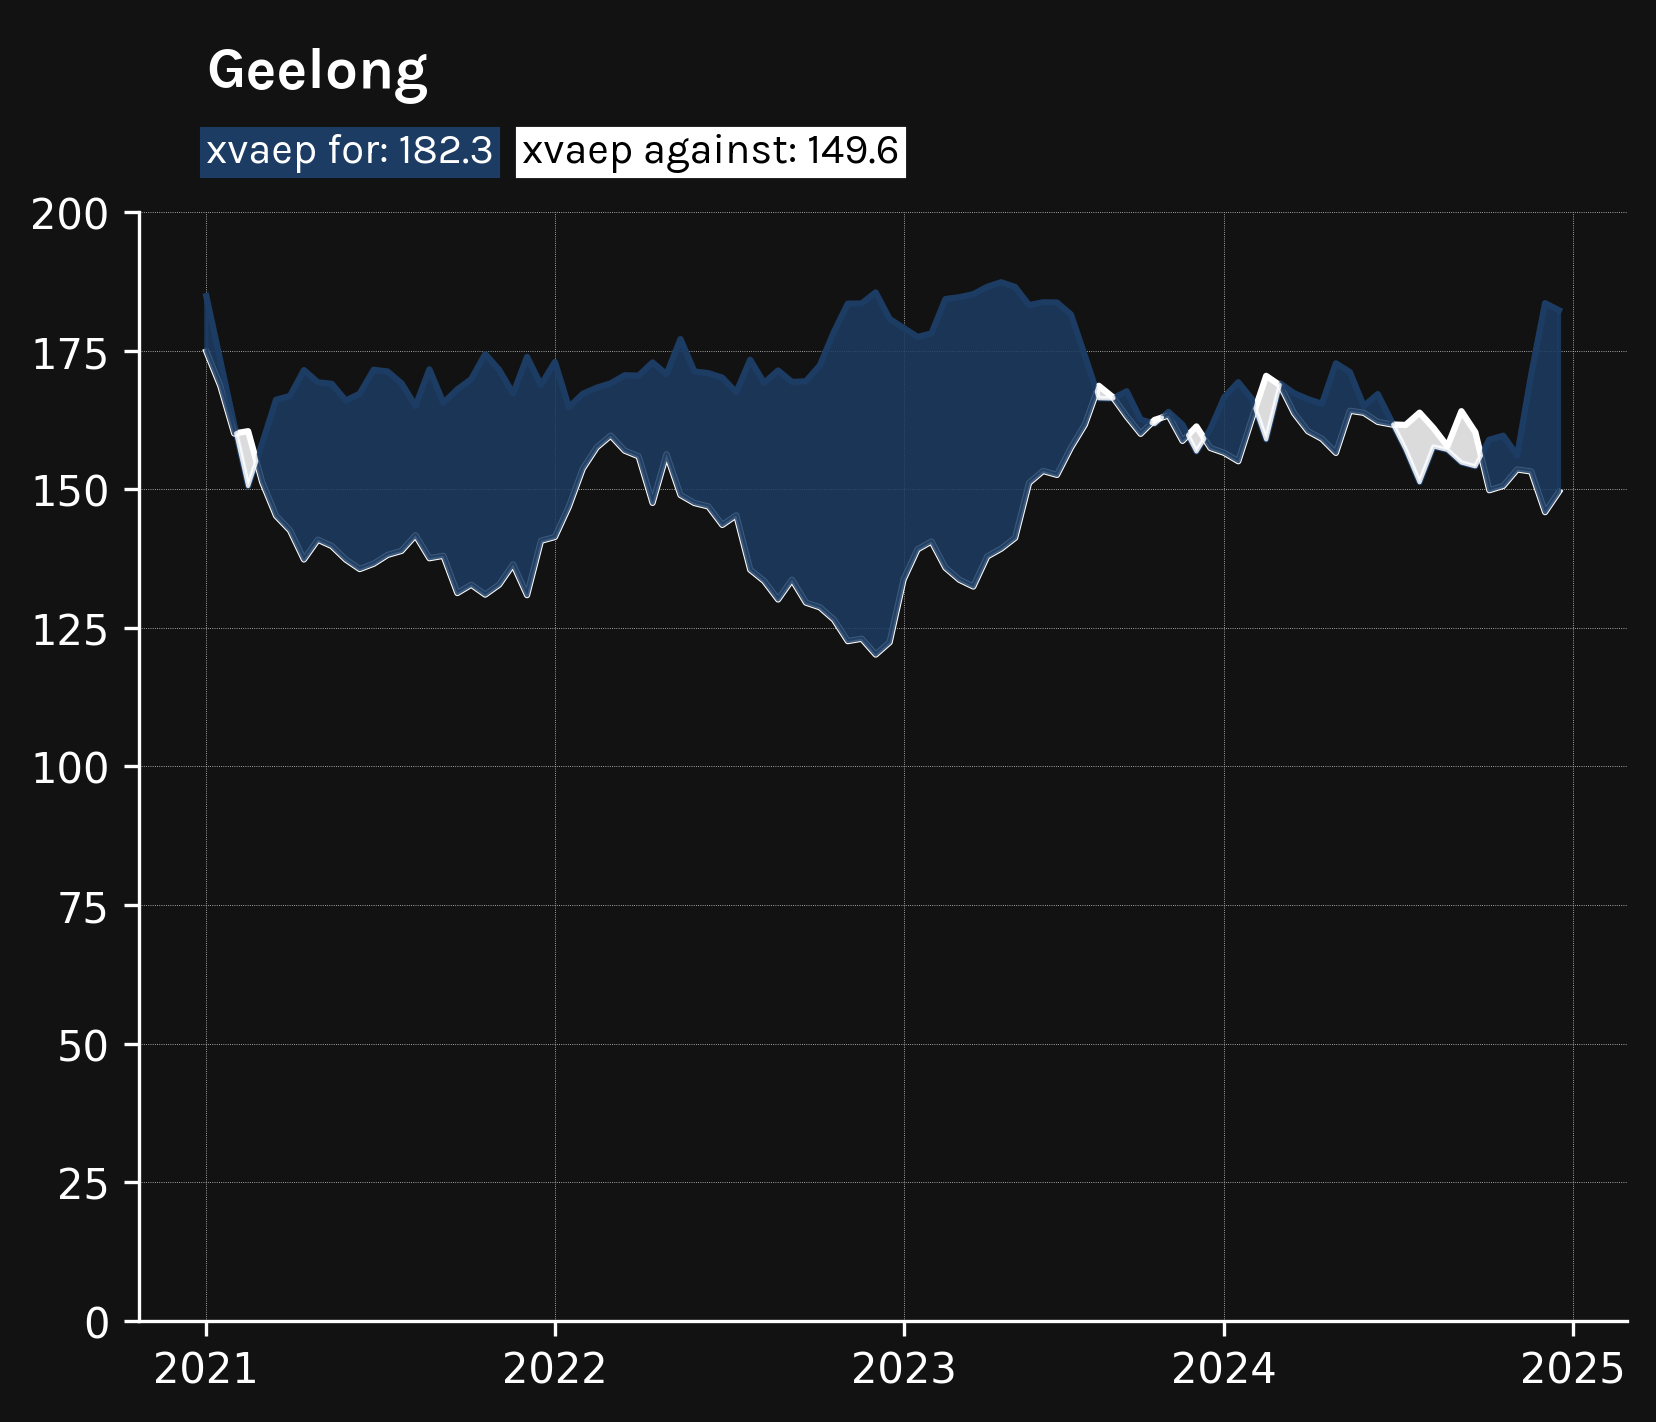

In [36]:
team = 'Geelong'
window = 10
metric = 'exp_vaep_value'
# years = [2023, 2024]
# year_shots = shots[shots['Year'].isin([2023, 2024])]
team_rolling = create_team_rolling(xchains, team, window, metric='exp_vaep_value')
fig, ax = plt.subplots()
ax = plot_team_rolling_ax(ax, team, team_rolling, annotate=True)

In [37]:
# fig.savefig('../_figures/geelong_rolling_averages_dark.png', format='png', bbox_inches='tight')

Plot All Teams

In [ ]:
def plot_all_team_rolling_figure(chains, window, metric = 'xvaep', annotate = True, add_title=True, years = None):
    
    fig = plt.figure(figsize=(18, 24), dpi=300)

    nrows=6
    ncols=3
    gspec = gridspec.GridSpec(
        ncols=ncols, nrows=nrows, figure=fig,
        hspace=0.3
    )
    
    team_list = list(team_colours.keys())
    for plot_counter, (row, col) in enumerate(itertools.product(range(nrows), range(ncols))):
        team = team_list[plot_counter]
        ax = plt.subplot(gspec[row, col])
        team_rolling = create_team_rolling(chains, team, window, metric)
        ax = plot_team_rolling_ax(ax, team, team_rolling, annotate = annotate, years = years)
        
    if add_title:
        fig_text(
            x=0.13, y=0.91,
            s = "AFL - xvaep for & against - 10-game rolling average.",
            size = 22,
            font = "Karla"
        )
    
    return fig, ax

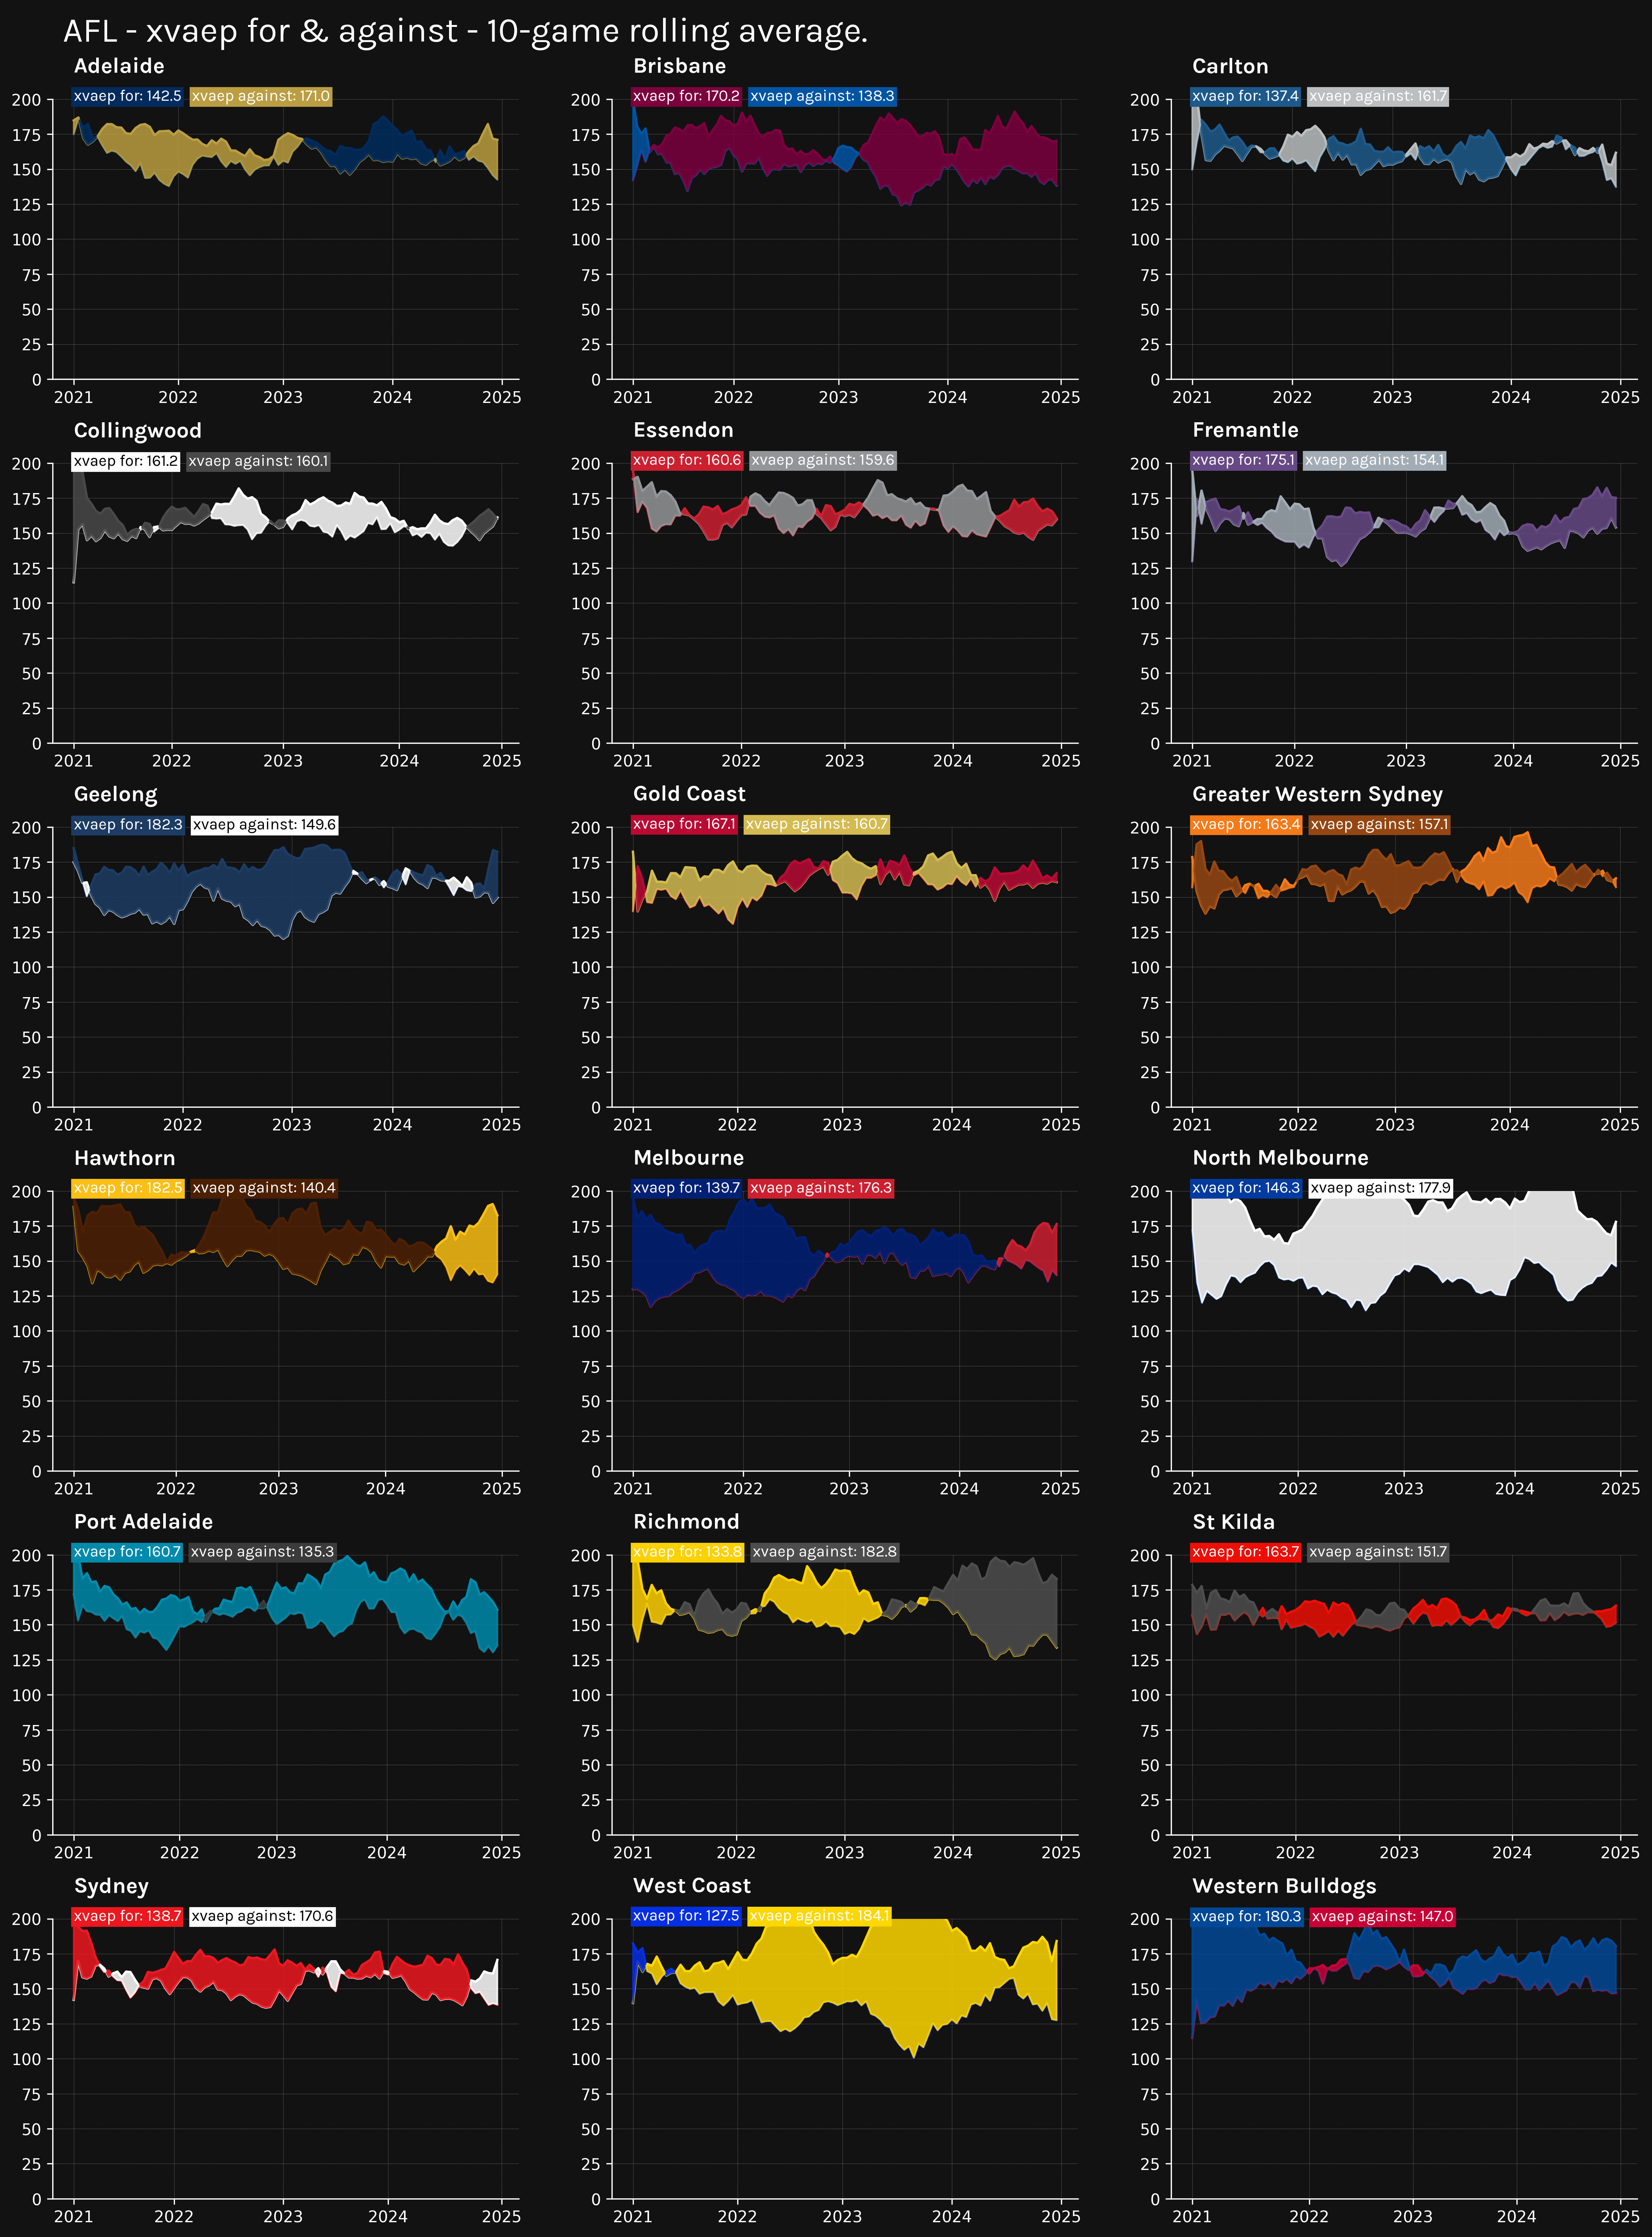

In [39]:
fig, ax = plot_all_team_rolling_figure(xchains, window, metric = 'exp_vaep_value')

In [ ]:
# fig.savefig('../_figures/team_rolling_averages_dark.png', format='png', bbox_inches='tight')